# Problem Set 1: LHC data analysis with neural networks

**Software requirements:**
You will need a few special software packages, including `uproot` and `pylorentz`, for this problem set. (Both are installable via `pip`.)

**Datasets:**
I recommend creating a folder called something like `data/pset_1` wherever you are working on this problem set. The datasets can be downloaded at this link: https://uwmadison.box.com/s/bjlt381q7x4eufw70uq84nbx969onxn5 

**Grading:**
This problem set will be graded as a quiz within Canvas.

**Deadline:** 
The Canvas quiz will close on Friday, September 19th at 11:59pm Central Time.

# Tau identification

This section uses highly realistic simulations that have actually been used to help develop new triggers at the LHC. These triggers need to make decisions ~40 million times per second! 

The signal sample consists of well-defined taus from simulated Higgs boson decays into tau pairs ($H\rightarrow\tau\tau$). The background sample consists of a mix of unbiased background events and high-momentum QCD jets. Including both sources of backgrounds helps us to construct a model that works well even for high-momentum events.

In these problems, you will train a **classification model** where the output is a probability score for whether the input object is a tau lepton or not.

In [1]:
import random
import uproot
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

In [2]:
### don't change this cell -- setting a seed will ensure that your answers are consistent 
seed = 1234 
random.seed(seed)
np.random.seed(seed)
torch.random.manual_seed(seed) 

In [3]:
### set plot resolution
%config InlineBackend.figure_format = 'retina'

### set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

### Load the data

Note that `X` usually refers to the inputs and `y` refers to the true labels.

In [4]:
def create_train_test_data(folder, n_vars=1, n_events=100_000):        
    sig = uproot.open(folder+"test_sig_v12_emseed.root")
    bkg = uproot.open(folder+"test_bkg_v12_emseed.root")
    qcd = uproot.open(folder+"test_qcd_v12_emseed.root")

    sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()
    bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()
    qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

    truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()) # Not used?

    # Selection on signal
    reco_pt_sig  = sig['ntuplePupSingle']['tree']['pt'].array()
    deltaR_sig   = sig['ntuplePupSingle']['tree']['gendr1'].array()
    eta_sig      = sig['ntuplePupSingle']['tree']['geneta1'].array()
    selection_sig = (reco_pt_sig > 12.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4) # Why this particular selection?

    # Selection on background and QCD
    selection_bkg = (bkg['ntuplePupSingle']['tree']['pt'].array() > 12) 
    selection_qcd = (qcd['ntuplePupSingle']['tree']['pt'].array() > 12)

    # Inputs: pT, eta, phi, particle ID (one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig][0:n_events])) # Also sets NaNs to zero
    y_sig = np.full(X_sig.shape[0], 1.) # Returns an array of shape (X_sig.shape[0],) filled with 1.0s

    X_bkg    = np.nan_to_num(np.asarray(bkg_input)[selection_bkg][0:n_events])
    y_bkg    = np.full(X_bkg.shape[0], 0.)
    
    X_qcd    = np.nan_to_num(np.asarray(qcd_input)[selection_qcd][0:n_events])
    y_qcd    = np.full(X_qcd.shape[0], 0.)
    
    print("Signal Samples",len(y_sig),"label:",y_sig[0])
    print("Bkg Samples",len(y_bkg),"label:",y_bkg[0])
    print("QCD Samples",len(y_qcd),"label:",y_qcd[0])
    
    X = np.concatenate([X_sig, X_bkg, X_qcd])
    y = np.concatenate([y_sig, y_bkg, y_qcd])
    
    ### Data cleaning
    X[abs(X) > 1e+9] = 0.    
    if n_vars > 0: # select only the first n_vars variables
        X = X[:,0:n_vars]
    
    ### Convert to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    
    return X, y

In [5]:
# X, y = create_train_test_data("./data/pset_1/")
X, y = create_train_test_data("./data/")

Signal Samples 100000 label: 1.0
Bkg Samples 100000 label: 0.0
QCD Samples 100000 label: 0.0


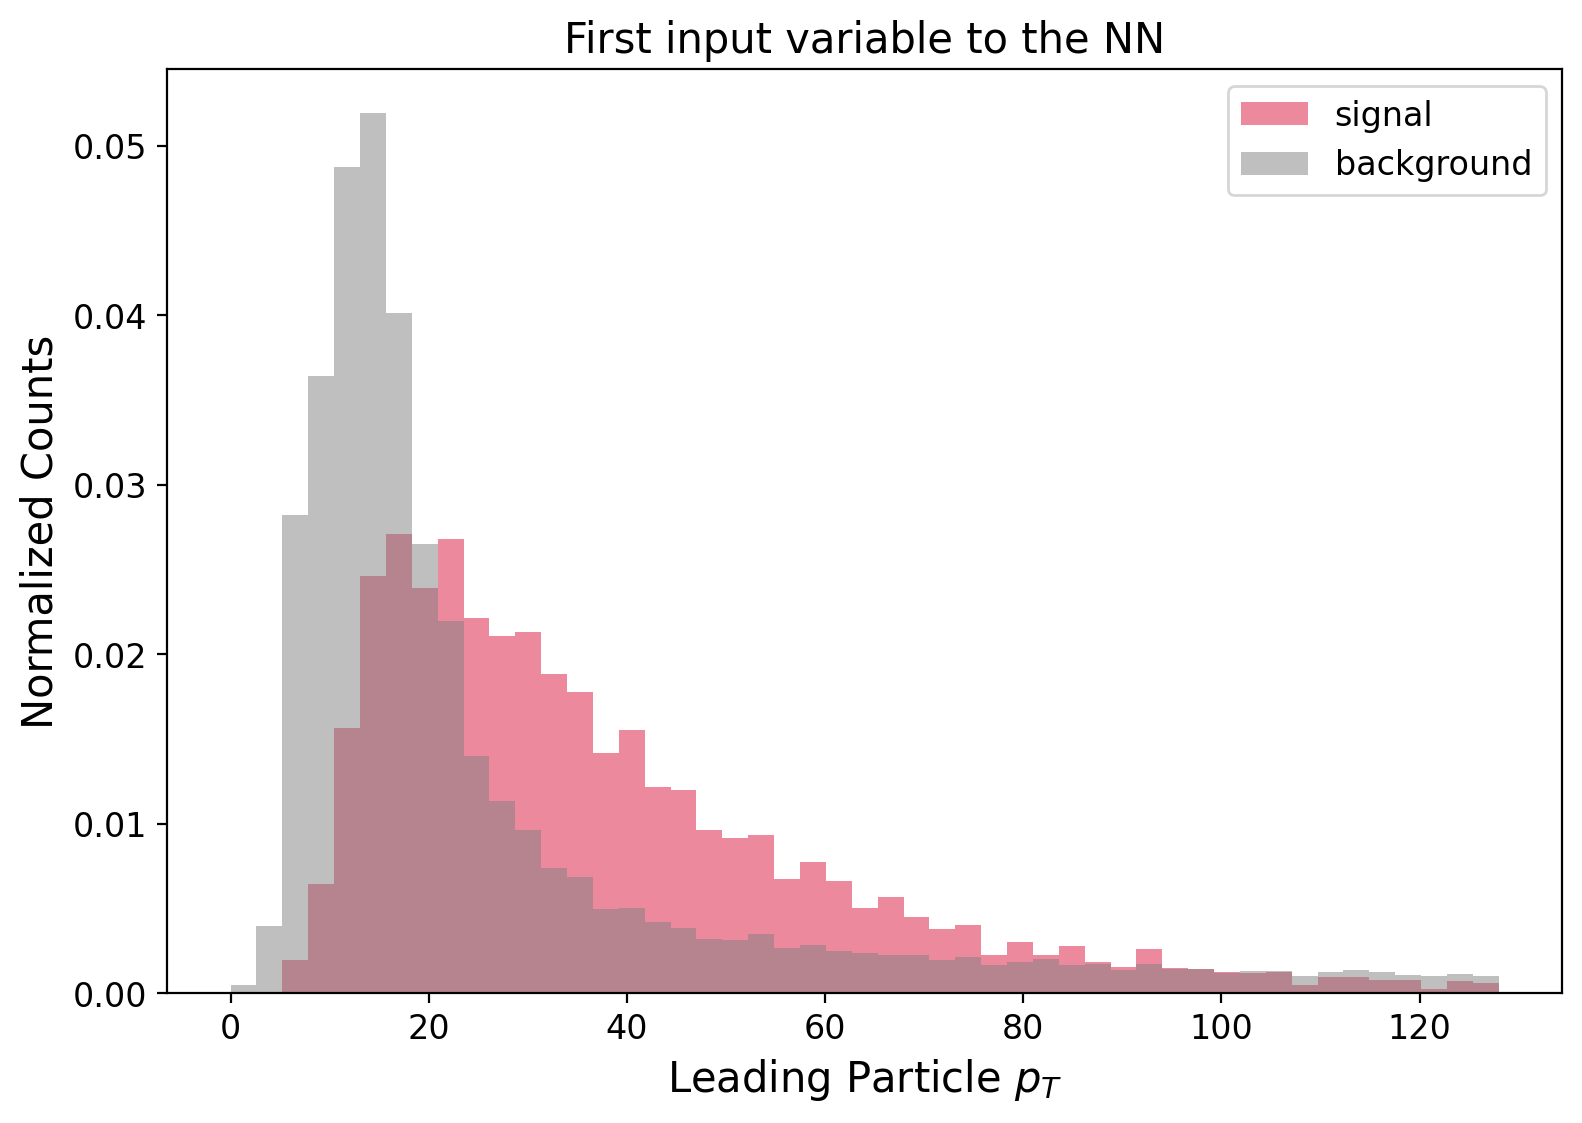

In [6]:
bins = np.linspace(0, 128, 50)
plt.hist(X[:,0][y == 1], bins=bins, color="crimson", label="signal", alpha=0.5, density=True)
plt.hist(X[:,0][y == 0], bins=bins, color="grey", label="background", alpha=0.5, density=True)
plt.xlabel(r"Leading Particle $p_T$")
plt.ylabel(r"Normalized Counts")
plt.title("First input variable to the NN")
plt.legend()
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem 1: Train/val/test splits</span>

Now we want to make to split the dataset into 3 components so that we can validate the training:

- **Training set:** Used to train the neural network's trainable parameters
- **Validation set:** Used to check for signs of overtraining during the training process
- **Test set:** Used to evaluate the performance of the trained model

Using the code below as a starting point, split the data into: 60% training, 20% validation, and 20% test. How many events do you see in train, validation, and test? 

In [7]:
def train_val_test_split(X, y, train_frac=0.6):
    dataset = torch.utils.data.TensorDataset(X, y)
    # TIP: Check out the documentation here: https://pytorch.org/docs/stable/data.html

    train_size = int(train_frac * len(dataset))
    val_test_size = len(dataset) - train_size
    val_size = val_test_size // 2
    test_size = val_size

    train, val_and_test = torch.utils.data.random_split(dataset, [train_size, val_test_size])
    val, test           = torch.utils.data.random_split(val_and_test, [val_size, test_size])
    
    return train, val, test

In [8]:
train, val, test = train_val_test_split(X, y)
print(f"Training set has {len(train):,} events.")
print(f"Validation set has {len(val):,} events.")
print(f"Test set has {len(test):,} events.")

Training set has 180,000 events.
Validation set has 60,000 events.
Test set has 60,000 events.


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem 2: Average score before training</span>

Now we'll construct a neural network with a single layer (i.e. no hidden layers) that applies a sigmoid output. 

Create the network and then apply it directly to the test dataset. 

What is the average output value of this network, before we've even trained it? Report a number with precision 1e-3.

In [9]:
class NN_1layer(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid() # apply a sigmoid activation here

    def forward(self, x):
        x = self.layer1(x)
        x = self.sigmoid(x)
        return x

model = NN_1layer(input_dim = 1) # we're only using one input variable for now
output = model(test[:][0])
print("Mean output on untrained model:")
print(f"{output.detach().cpu().numpy().mean():.3f}")

Mean output on untrained model:
0.938


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem 3: Average loss before training</span>

Calculate the binary cross-entropy loss on the test dataset (again, remember -- we haven't trained anything yet, so this is a randomly-initialized model). What is your loss? Report a number with precision 1e-1. 

In [10]:
y_true = test[:][1]

In [11]:
loss_fn = nn.BCELoss()
loss = loss_fn(output.flatten(), y_true)
print("Test loss on untrained model with only one input variable:")
print(f"{loss.detach().numpy().mean():.1f}")

Test loss on untrained model with only one input variable:
31.4


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem 4: Losses after 10 epochs</span>

Now that we've developed an intuition for how well the model can perform with no training and with a single input variable (translation: not very well!), we'll train a full version of this model.

What is the test loss after 10 epochs? Report your answer with precision 1e-2.

In [12]:
def train_model(model, loss_fn, train, val, n_epochs=5, learning_rate=0.01, batch_size=1000):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) ### add Adam optimizer with learning rate of 0.01 
    liveloss = PlotLosses(figsize=(9, 4)) 
    logs     = {}

    ### DataLoaders 
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader   = torch.utils.data.DataLoader(val, batch_size=batch_size)
    
    for epoch in range(n_epochs):
        current_loss = 0.0 # reset the loss at the start of each epoch
        for i, batch in enumerate(train_loader):
            model.train()
            x_batch, y_batch = batch

            optimizer.zero_grad() ### zero out the optimizer
            preds = model(x_batch).squeeze(1)
            loss = loss_fn(preds, y_batch) ### calculate the loss
            loss.backward() ### backpropagate the loss
            optimizer.step() ### apply a step to the optimizer
            current_loss += loss.item()
        
            if i == len(train_loader)-1: # i.e. on the last batch of the epoch

                ### validation loop
                model.eval()
                current_val_loss = 0.0
                with torch.no_grad():
                    for iv, val_batch in enumerate(val_loader):
                        x_val_batch, y_val_batch = val_batch
                        val_preds = model(x_val_batch).squeeze(1) ### fill these in
                        val_loss = loss_fn(val_preds, y_val_batch) ### fill these in
                        current_val_loss += val_loss.item()
                    print('[%d, %4d] loss: %.4f  val loss: %.4f' % 
                          (epoch + 1, i + 1, current_loss/float(i+1) , current_val_loss/float(len(val_loader))))
                logs['loss'] = current_loss/float(i+1)
                logs['val_loss'] = current_val_loss/float(len(val_loader))

        liveloss.update(logs)
        liveloss.send()
        
    return logs

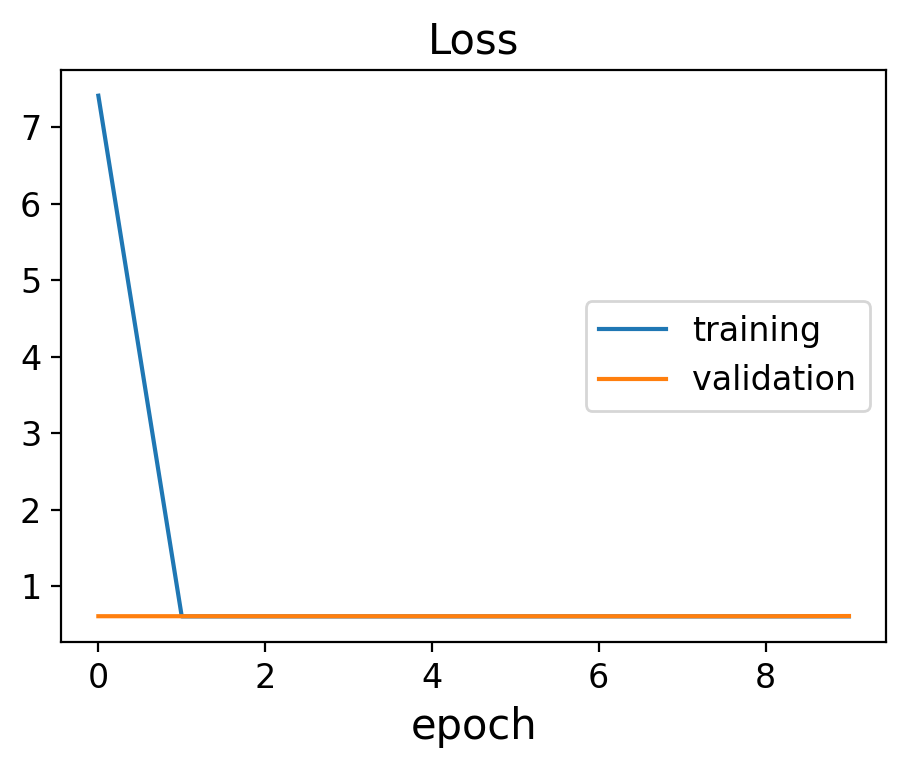

Loss
	training         	 (min:    0.609, max:    7.413, cur:    0.609)
	validation       	 (min:    0.611, max:    0.614, cur:    0.614)


In [13]:
model = NN_1layer(input_dim = 1) ### define a fresh instance of your model
logs = train_model(model, loss_fn, train, val, n_epochs=10)

Evaluate the trained model on the test set:

In [14]:
model.eval()
with torch.no_grad():
    test_loss =  loss_fn(
        model(test[:][0]).squeeze(1),
        test[:][1]
    )
print(f"Train loss: {logs['loss']:.2f}, Val loss: {logs['val_loss']:.2f}, Test loss: {test_loss:.2f}")

Train loss: 0.61, Val loss: 0.61, Test loss: 0.61


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem 5: ROC Curve</span>

One way of understanding the performance of our model is to calculate the area under the curve (AUC) of the ROC curve. This curve is constructed by plotting the true positive rate, i.e. the signal efficiency, vs. the false positive rate, i.e. the background efficiency. A well-trained classifier will have a high signal efficiency and low background efficiency. Report the AUC of the ROC curve you calculate below with precision 1e-2.

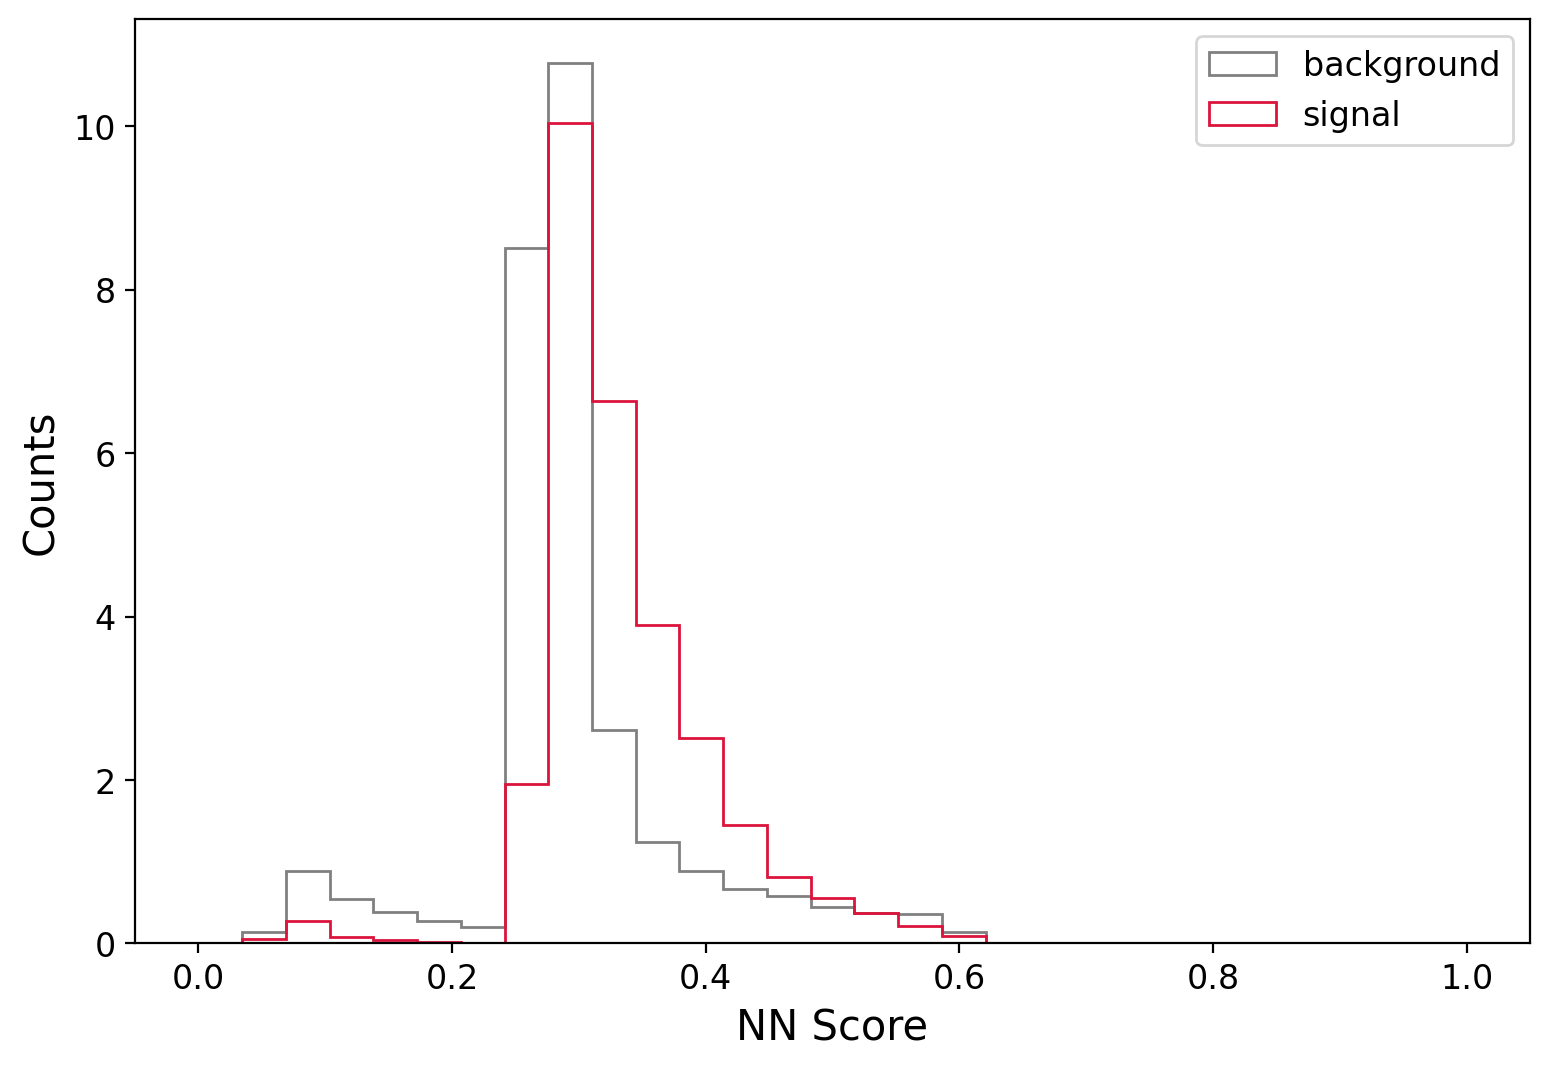

In [15]:
from sklearn import metrics

preds = model(test[:][0]).squeeze(1) ### compute the NN scores (i.e. final output values) on the test dataset
labels = test[:][1] ### labels on the test dataset

bins = np.linspace(0, 1, 30) ### 30 points spread between 0 and 1
plt.hist(preds[labels==0].detach().numpy(), histtype='step',color='grey', density=True,label='background',bins=bins)
plt.hist(preds[labels==1].detach().numpy(), histtype='step',color='crimson',density=True,label='signal',bins=bins)
plt.xlabel('NN Score')
plt.ylabel('Counts')
plt.legend()
plt.show()

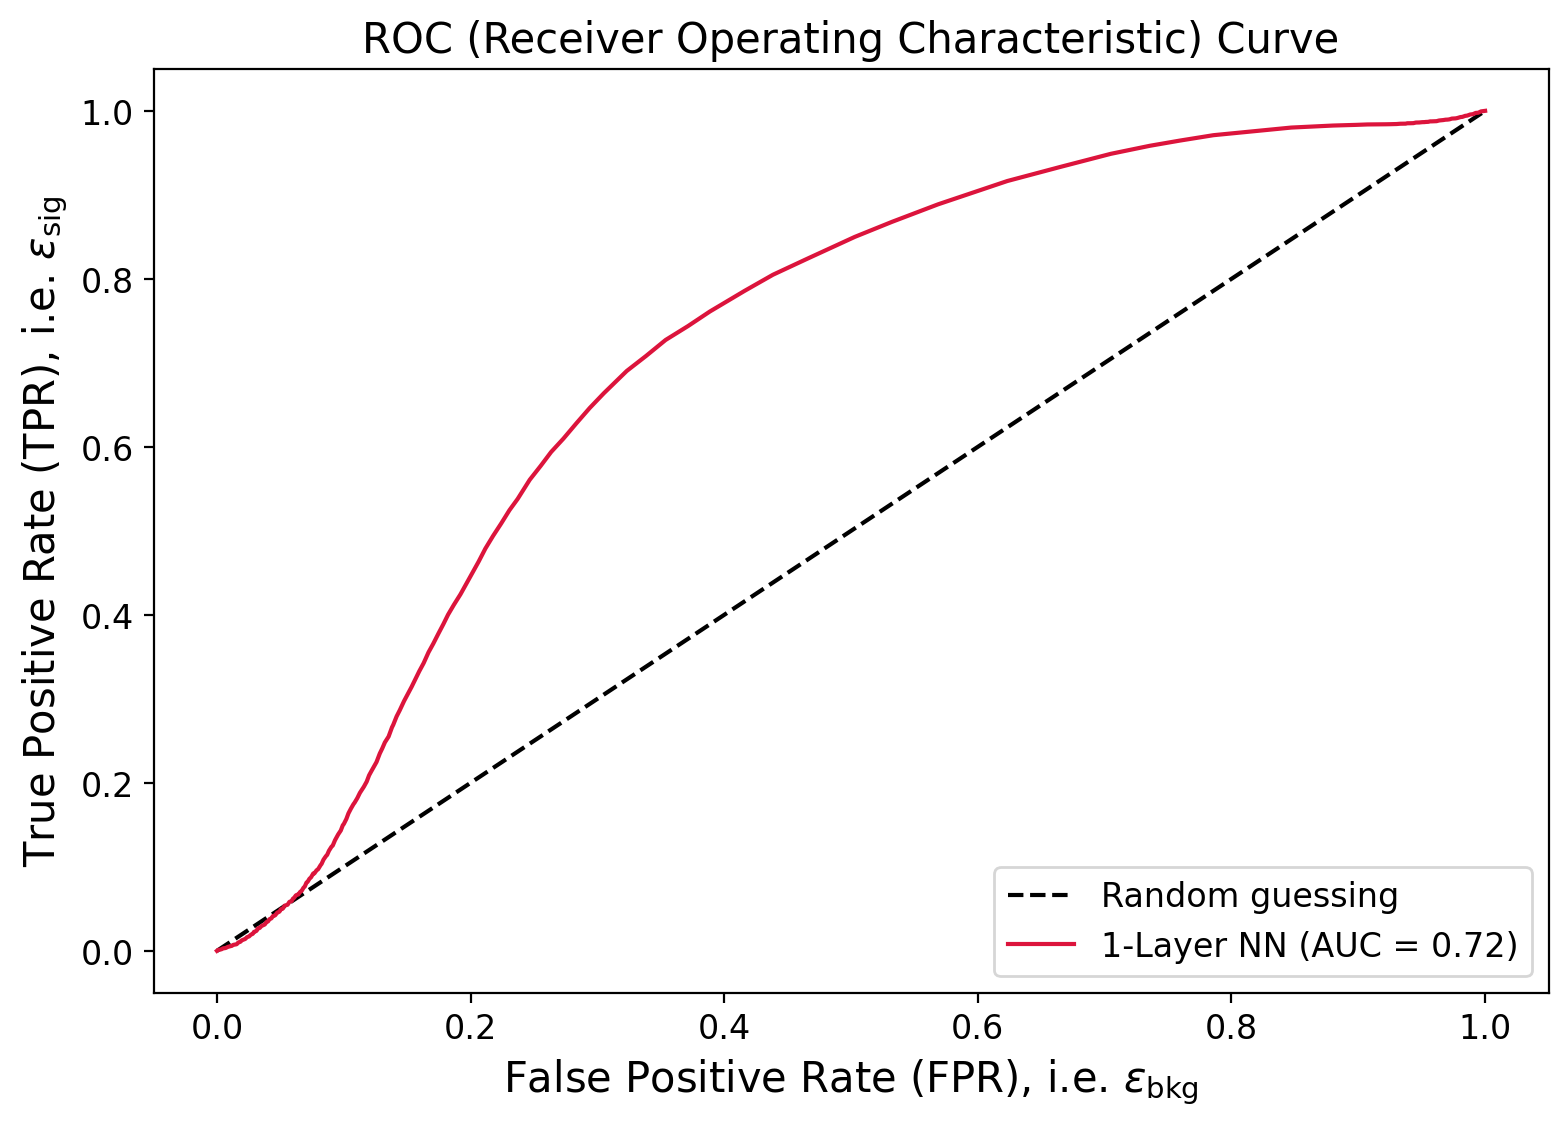

AUC = 0.72


In [16]:
def compute_ROC(labels, preds, n_points=501):
    cut_vals = np.linspace(0, 1, n_points)
    tot0 = float(len(labels[labels == 0]))  # number of background events
    tot1 = float(len(labels[labels == 1]))  # number of signal events
    tpr = []
    fpr = []
    with torch.no_grad():
        for c in cut_vals:
            pass_bkg = (labels == 0) & (preds > c) ### boolean indicating background and NN scores are larger than the cut value ("c")
            pass_sig = (labels == 1) & (preds > c) ### boolean indicating signal and NN scores are larger than the cut value ("c")
            fpr.append(sum(pass_bkg.numpy()) / tot0)
            tpr.append(sum(pass_sig.numpy()) / tot1)
    return np.array(fpr), np.array(tpr)

fpr, tpr = compute_ROC(labels, preds)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="dashed", color="k", label="Random guessing")
plt.plot(fpr, tpr,color="crimson",label=f"1-Layer NN (AUC = {metrics.auc(fpr, tpr):.2f})")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel(r"False Positive Rate (FPR), i.e. $\epsilon_{\text{bkg}}$")
plt.ylabel(r"True Positive Rate (TPR), i.e. $\epsilon_{\text{sig}}$")
plt.legend(loc="lower right")
plt.show()

print(f"AUC = {metrics.auc(fpr, tpr):.2f}")

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem 6: 3-layer NN on the full dataset</span>

We've now benchmarked the performance of this very simple one-layer neural network using just one input variable (!). Let's make a new model that's more expressive.

Make a new model below that includes: 
- Training on all 80 of the input variables
- 3 linear layers
- Hidden dimension of 32 nodes
- ReLU activations

What is the test loss after 10 epochs? Report your answer with precision 1e-2.

In [17]:
# X, y = create_train_test_data("./data/pset_1/", n_vars=-1) # -1 means we'll use all the available input variables
X, y = create_train_test_data("./data/", n_vars=-1)
train, val, test = train_val_test_split(X, y)
print(f"Training set has {len(train):,} events.")
print(f"Validation set has {len(val):,} events.")
print(f"Test set has {len(test):,} events.")

Signal Samples 100000 label: 1.0
Bkg Samples 100000 label: 0.0
QCD Samples 100000 label: 0.0
Training set has 180,000 events.
Validation set has 60,000 events.
Test set has 60,000 events.


In [18]:
X.shape # you should see 80 as the second dimension, indicating 80 input variables

torch.Size([300000, 80])

**Input variable definitions:** The 80 input variables to the NN correspond to 8 variables for the top 10 particles in each jet, ranked in descending order in momentum. 

The 8 variables for each of the 10 particles are: 
- pT 
- $\theta$ (really $\eta$) of the particle from the center of the jet
- $\phi$ of the particle from the center of the jet
- 5 particle ID labels (one-hot encoded, i.e. 0 or 1): [pion, electron, muon, photon, neutral hadron])


In [19]:
class NN_3layer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        # self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu   = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Layer 1:
        x = self.layer1(x)
        x = self.relu(x)

        # Layer 2: 
        x = self.layer2(x)
        x = self.relu(x)

        # Layer 3 (i.e. output layer):
        x = self.output(x)
        x = self.sigmoid(x)
        return x

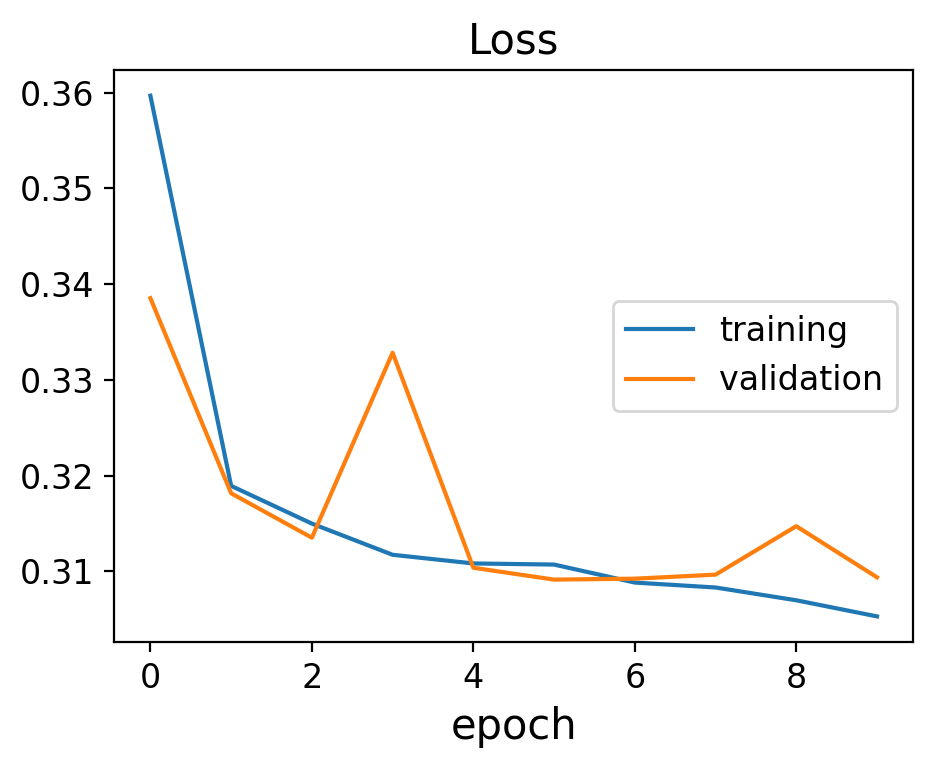

Loss
	training         	 (min:    0.305, max:    0.360, cur:    0.305)
	validation       	 (min:    0.309, max:    0.339, cur:    0.309)


In [20]:
model = NN_3layer(input_dim = 80, hidden_dim=32) ### define a fresh instance of your model
logs = train_model(model, loss_fn, train, val, n_epochs=10)

In [21]:
with torch.no_grad():
    test_loss =  loss_fn(
        model(test[:][0]).squeeze(1),
        test[:][1]
    )
print(f"Train loss: {logs['loss']:.2f}, Val loss: {logs['val_loss']:.2f}, Test loss: {test_loss:.2f}")

Train loss: 0.31, Val loss: 0.31, Test loss: 0.31


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem 7: 3-layer NN, 50 epochs</span>

Train a new instance of the same model for 50 epochs instead of 10 epochs and report the final test loss value with precision 1e-2.

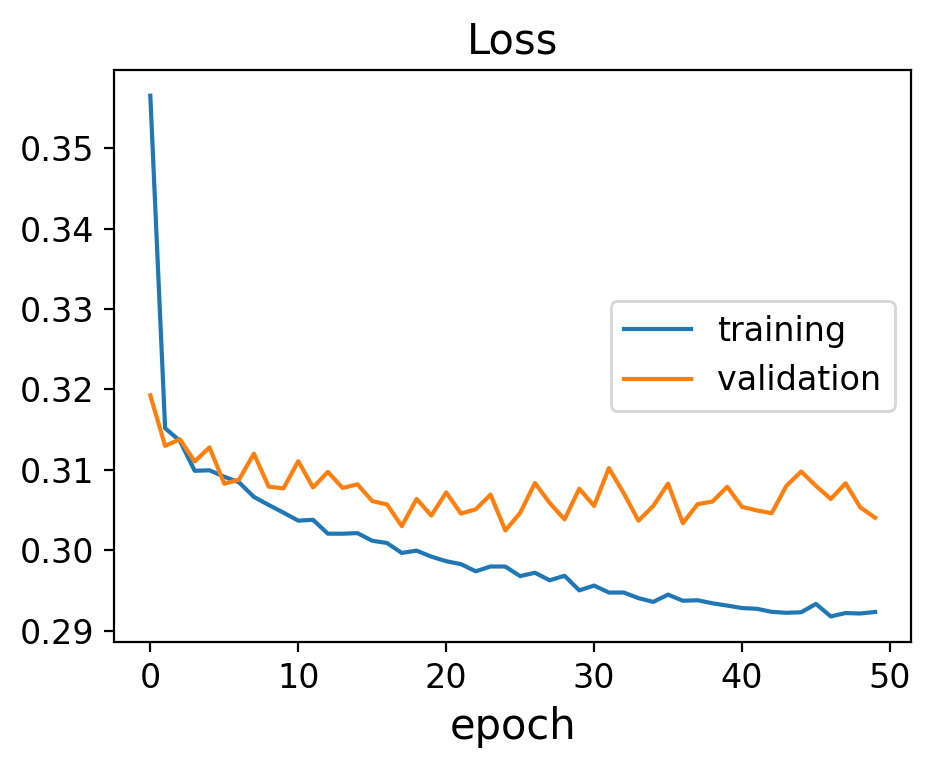

Loss
	training         	 (min:    0.292, max:    0.357, cur:    0.292)
	validation       	 (min:    0.302, max:    0.319, cur:    0.304)


In [22]:
model = NN_3layer(input_dim = 80, hidden_dim=32) ### define a fresh instance of your model
logs = train_model(model, loss_fn, train, val, n_epochs=50)

In [23]:
with torch.no_grad():
    test_loss =  loss_fn(
        model(test[:][0]).squeeze(1),
        test[:][1]
    )
print(f"Train loss: {logs['loss']:.2f}, Val loss: {logs['val_loss']:.2f}, Test loss: {test_loss:.2f}")

Train loss: 0.29, Val loss: 0.30, Test loss: 0.30


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem 8: ROC AUC, round 2</span>

Now report the ROC AUC for the model you just trained for 50 epochs with precision 1e-2.

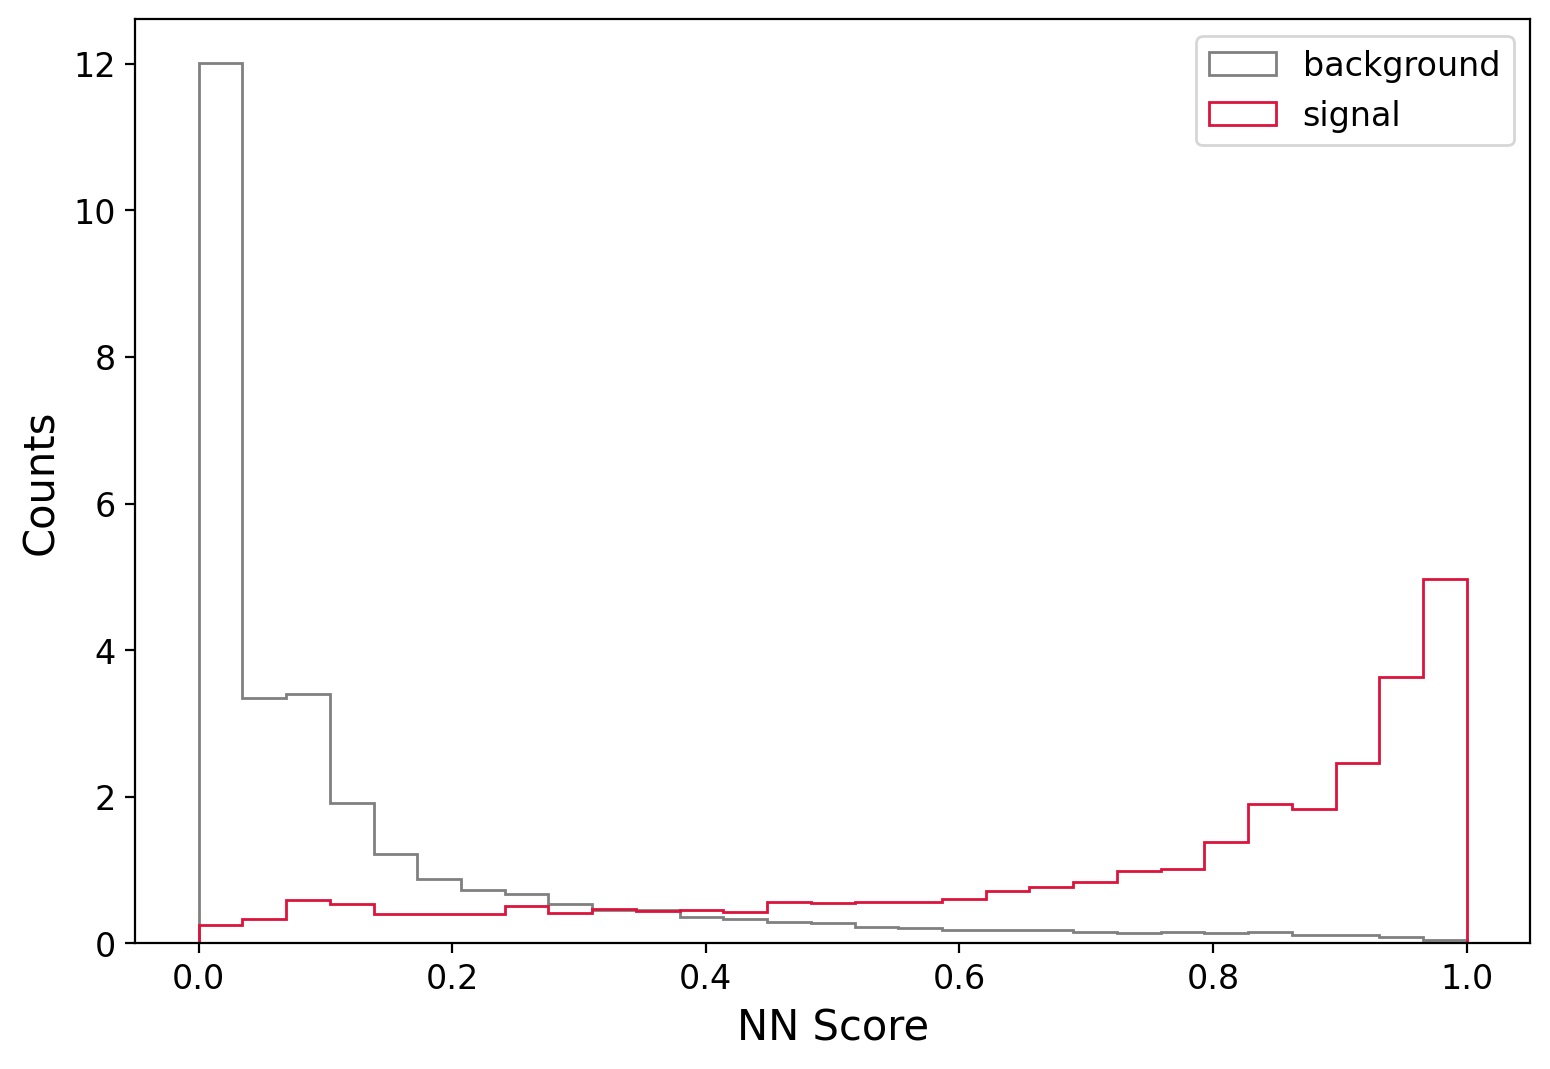

In [24]:
preds = model(test[:][0]).squeeze(1)
labels = test[:][1]

bins = np.linspace(0,1,30)
plt.hist(preds[labels==0].detach().numpy(), histtype='step',color='grey', density=True,label='background',bins=bins)
plt.hist(preds[labels==1].detach().numpy(), histtype='step',color='crimson',density=True,label='signal',bins=bins)
plt.xlabel('NN Score')
plt.ylabel('Counts')
plt.legend()
plt.show()

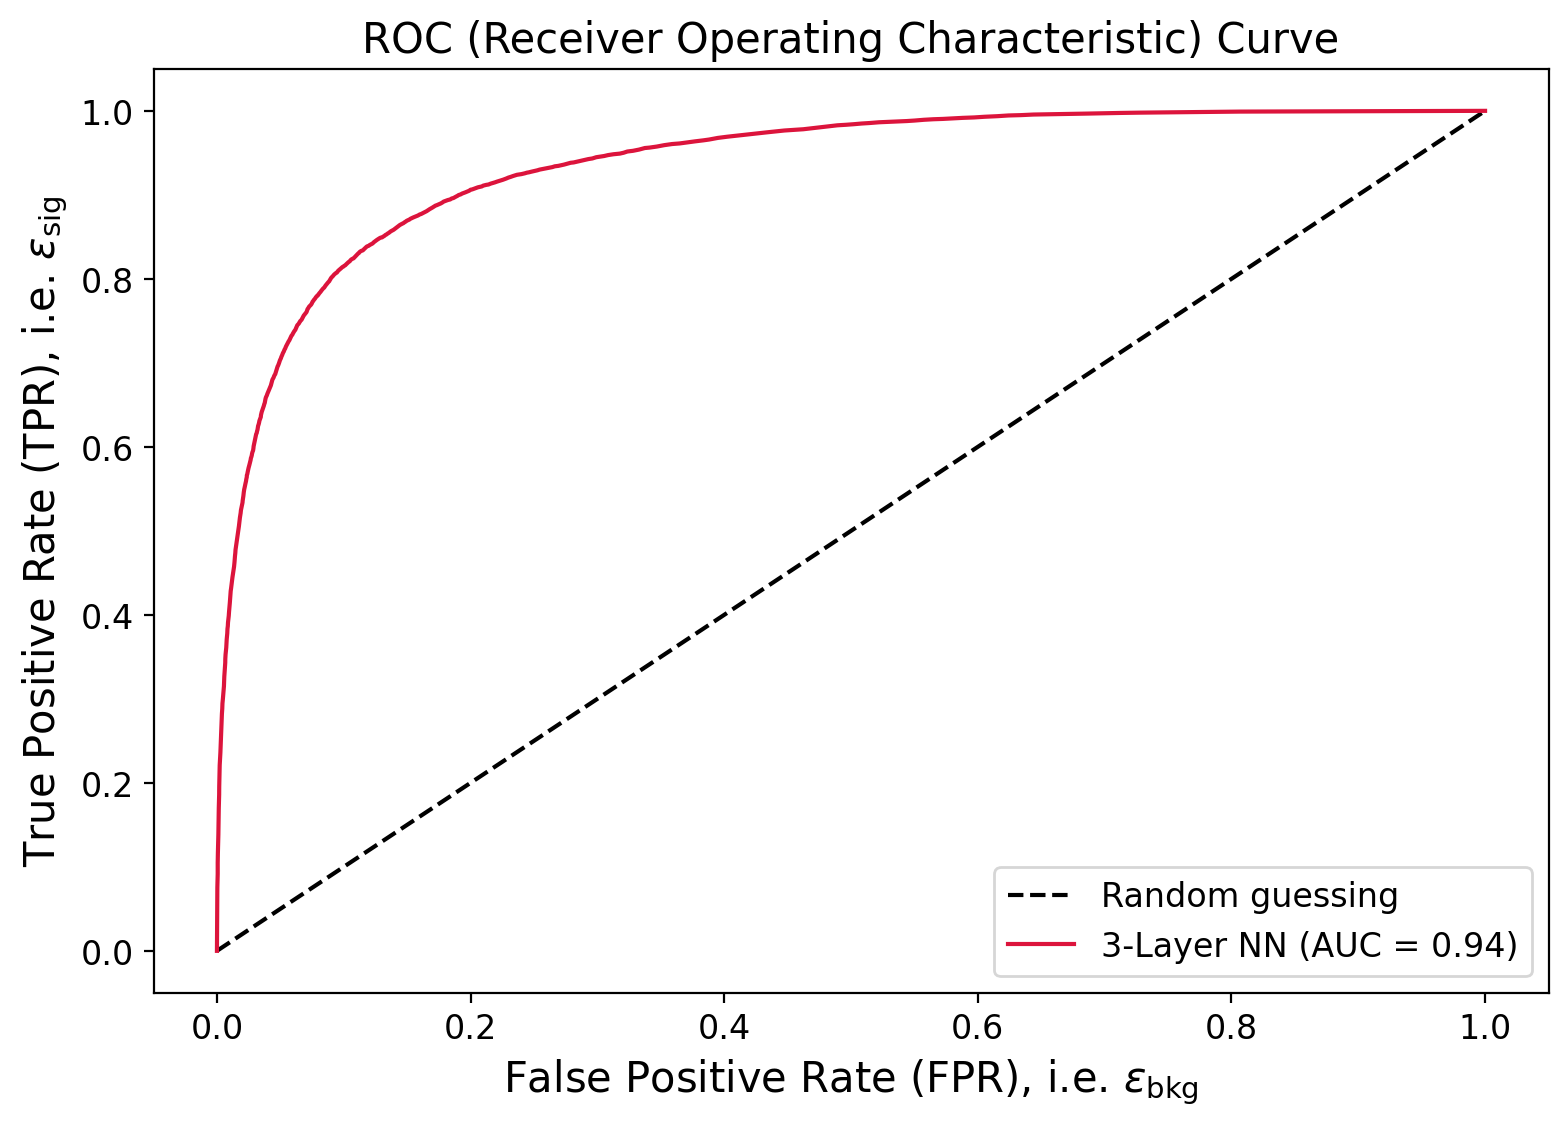

AUC = 0.94


In [25]:
fpr, tpr = compute_ROC(labels, preds)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="dashed", color="k", label="Random guessing")
plt.plot(fpr, tpr,color="crimson",label=f"3-Layer NN (AUC = {metrics.auc(fpr, tpr):.2f})")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel(r"False Positive Rate (FPR), i.e. $\epsilon_{\text{bkg}}$")
plt.ylabel(r"True Positive Rate (TPR), i.e. $\epsilon_{\text{sig}}$")
plt.legend(loc="lower right")
plt.show()

auc = metrics.auc(fpr, tpr)
print(f"AUC = {auc:.2f}")

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem 9: Applying a cut to the classifier score</span>

Now apply a cut on your NN classifier score at a threshold of 0.5 and compute the efficiency vs. leading particle pT (i.e. the first input). What is the NN doing? For example, examine the efficiency plot for pT = 30 GeV and pT = 100 GeV.

Try this out, then consider which of the following statements reflect your observations. Select ALL that apply:

- A) The signal efficiency drops quickly and has a low efficiency (~50%) for pT > 100 GeV
- B) The signal efficiency increases rapidly as a function of leading pT until it goes above 80% and then stays about the same 
- C) The signal efficiency is always high (> 80%) for all pTs even below 20 GeV
- D) The background efficiency peaks at 30 GeV with an efficiency of around 30%
- E) The background efficiency peaks at high pT (> 50 GeV) with an efficiency of around 30%
- F) The backround efficiency goes above 50% at some point

Answer: B, D

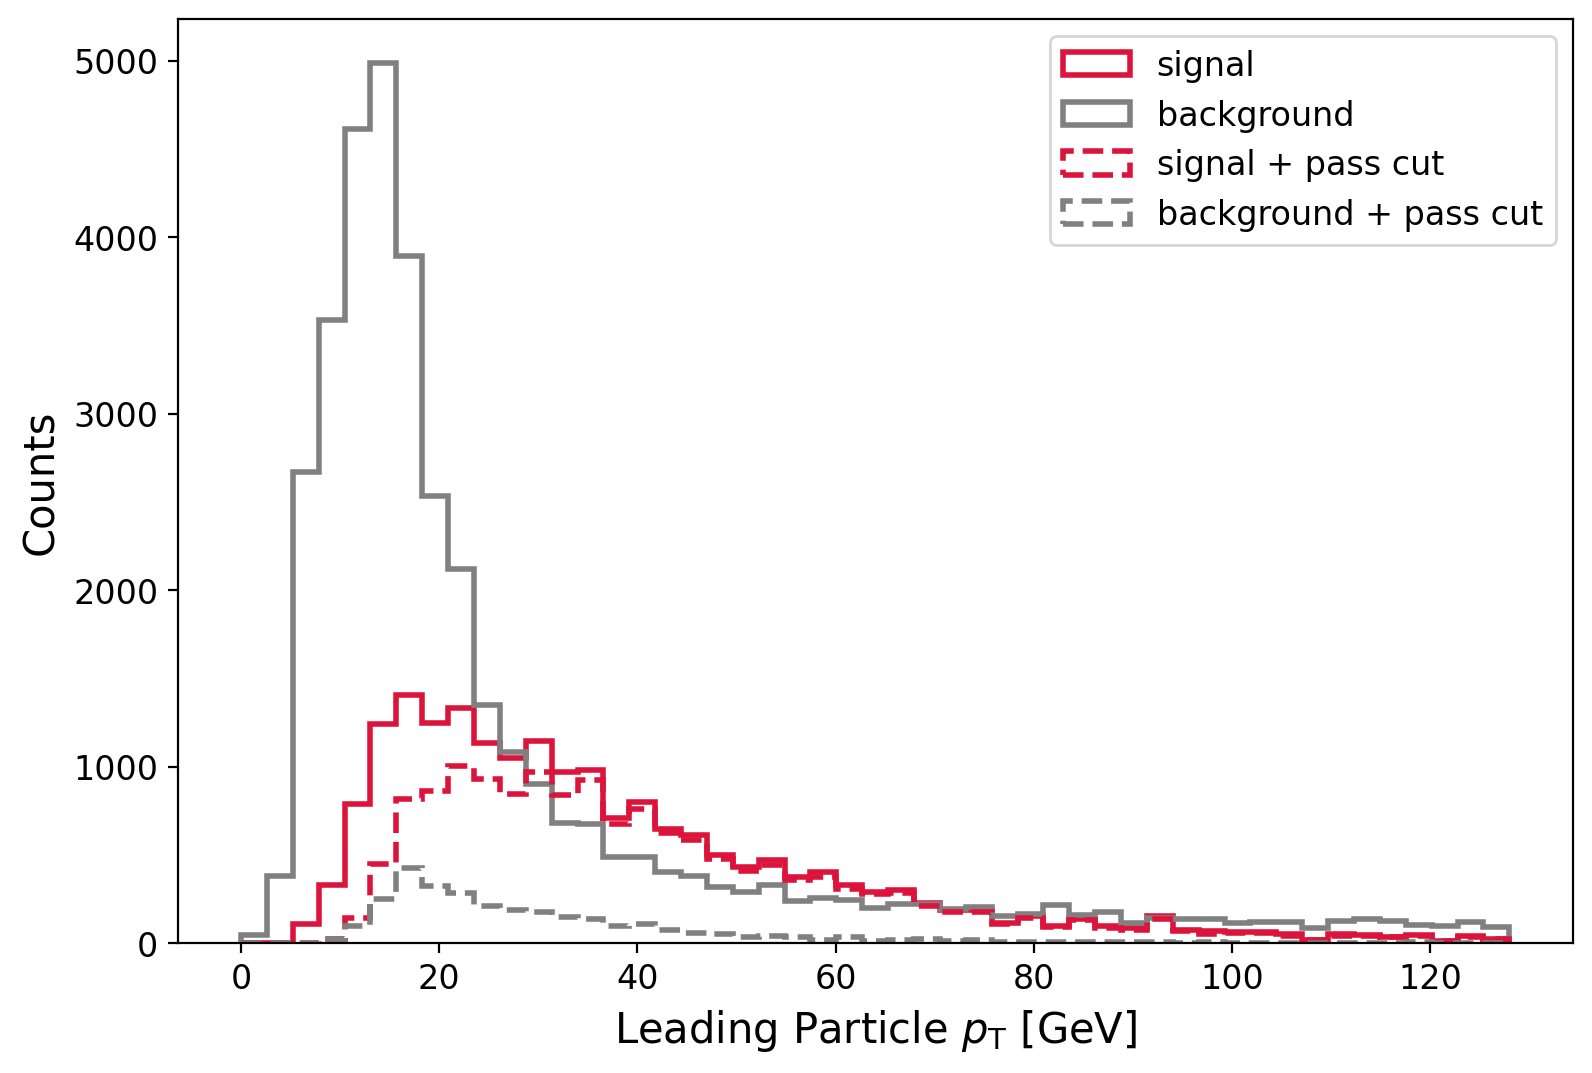

/tmp/ipykernel_2721584/386864928.py:17: RuntimeWarning: invalid value encountered in divide
  plt.plot(bincenter,countsSC/countsS,marker='.',label='signal')


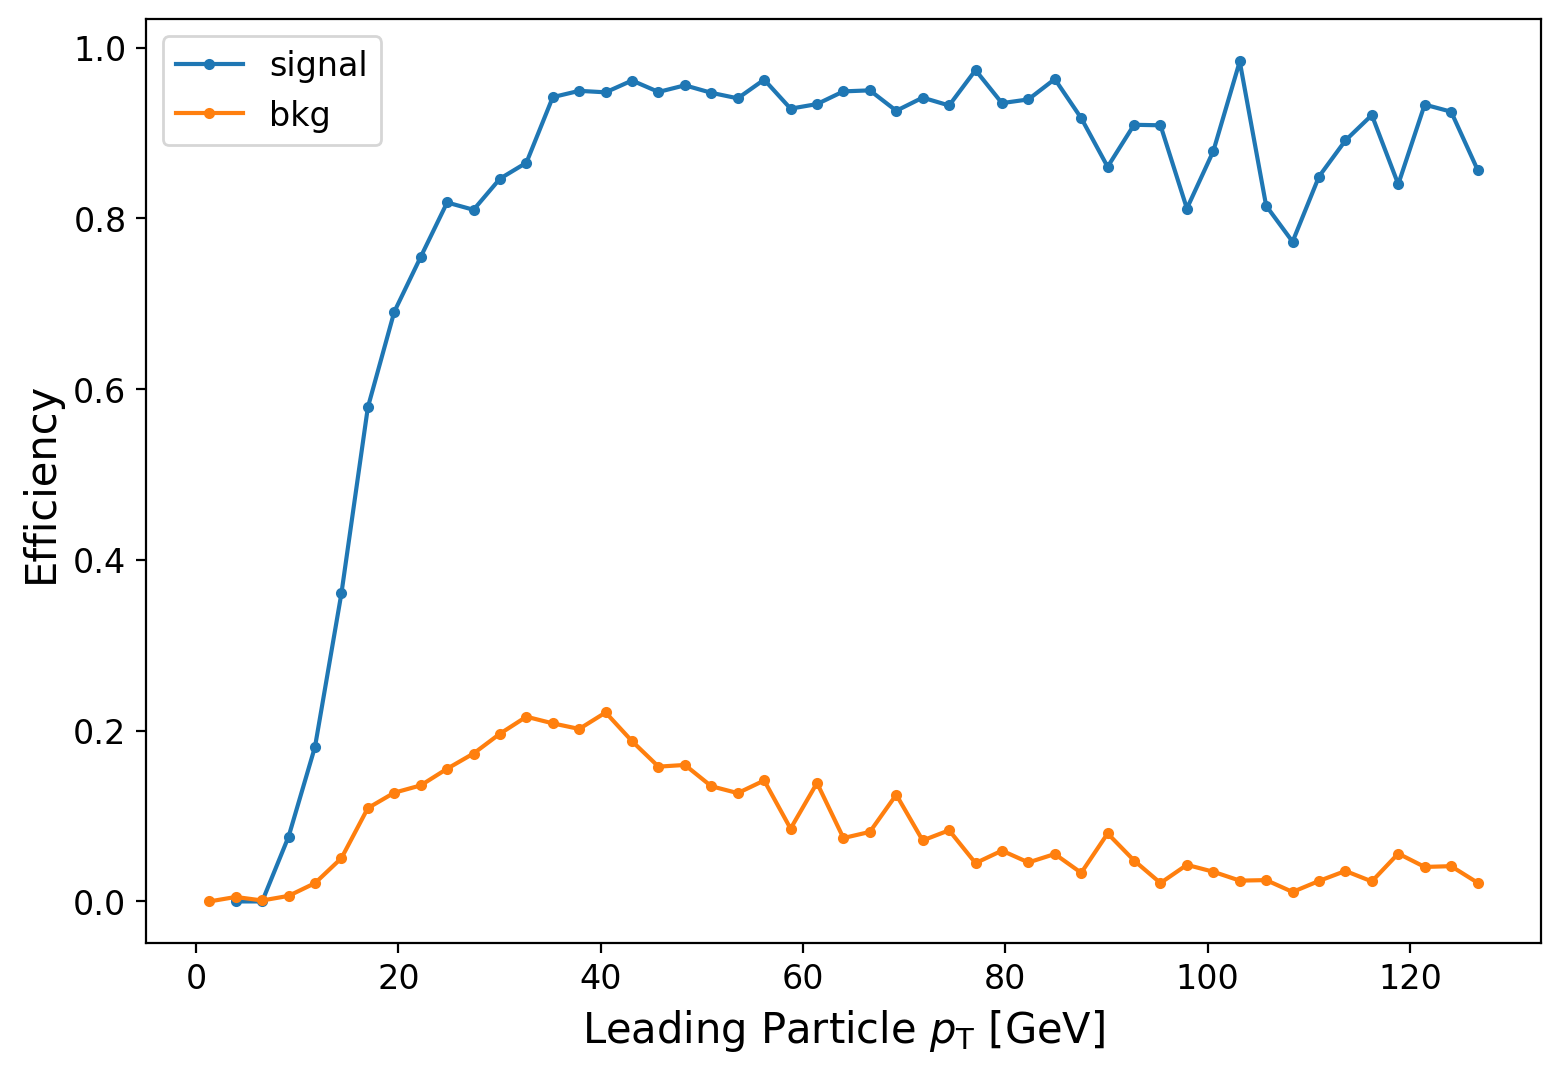

In [26]:
threshold = 0.5

with torch.no_grad():
    scores = model(test[:][0]).numpy()

bins = np.linspace(0, 128, 50)
countsS,bins,_ = plt.hist(test[:][0][:,0][test[:][1] == 1],bins=bins,label="signal", histtype='step', linewidth=2, color='crimson')
countsB,bins,_ = plt.hist(test[:][0][:,0][test[:][1] == 0], bins=bins,label="background", histtype='step', linewidth=2, color='gray')
countsSC,bins,_ = plt.hist(test[:][0][:,0][(scores.squeeze(1) > threshold) & (test[:][1] == 1).detach().numpy()],bins=bins,label="signal + pass cut", color='crimson', histtype='step', linewidth=2, linestyle='dashed')
countsBC,bins,_ = plt.hist(test[:][0][:,0][(scores.squeeze(1) > threshold) & (test[:][1] == 0).detach().numpy()],bins=bins,label="background + pass cut", color='gray', histtype='step', linewidth=2, linestyle='dashed')
plt.legend()
plt.xlabel(r"Leading Particle $p_{\text{T}}$ [GeV]")
plt.ylabel("Counts")
plt.show()

bincenter = 0.5*(bins[1:] + bins[:-1])
plt.plot(bincenter,countsSC/countsS,marker='.',label='signal')
plt.plot(bincenter,countsBC/countsB,marker='.',label='bkg')
plt.legend()
plt.ylabel('Efficiency')
plt.xlabel(r"Leading Particle $p_{\text{T}}$ [GeV]")
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem 10: Detecting a hidden signal</span>

**Challenge:** Finally, let's see if we can use this NN to find a hidden signal in the data. We will construct a dataset with a mystery mass peak comprising two taus that is injected to background events at a level of 1.5% (i.e. 750 events in 50,000). Given the output variables of the two taus, find the invariant mass of the hidden signal. Report your answer as a number with precision `1e1`.

In [27]:
from pylorentz import Momentum4

def calculate_invariant_mass(vector_1, vector_2):
    tau_1 = Momentum4.m_eta_phi_pt(vector_1[3], vector_1[1], vector_1[2], vector_1[0])
    tau_2 = Momentum4.m_eta_phi_pt(vector_2[3], vector_2[1], vector_2[2], vector_2[0])
    return (tau_1+tau_2).m

def make_dataset(mass_function, dataset):
    ### apply some basic quality cuts:
    mask=(dataset["pt2"].array() > 0)
    mask=(abs(dataset["eta2"].array()) < 2.1) & mask

    ### define input variables
    variables=["pt1","eta1","phi1","m1","pt2","eta2","phi2","m2"]
    arr=0
    idx=0
    for var in variables:
        pArr=dataset[var].array(library="np")[mask]
        if idx == 0: 
            arr = pArr
            idx = idx + 1
        else:
            arr=np.vstack((arr,pArr))
    arr = arr.T
    
    massc = lambda iarr: mass_function(iarr[0:4],iarr[4:8]) 
    masses = np.array([massc(p) for p in arr[0:50000]])
    inputs1 = dataset['m1_inputs'].array()
    inputs2 = dataset['m2_inputs'].array()
    inputs1 = np.nan_to_num(np.asarray(inputs1)[mask][0:50000])
    inputs2 = np.nan_to_num(np.asarray(inputs2)[mask][0:50000])
    return masses,inputs1,inputs2

def create_double_train_test_data(folder="./data/pset_1/"):
    import os
    # Open root files
    # Dataset description: For each event, the objects now are di-tau pairs. For each entry (i.e. di-tau pairs), you have the  
    sig = uproot.open(os.path.join(folder, "test_sig_v12_emseed.root"))
    bkg = uproot.open(os.path.join(folder, "test_bkg_v12_emseed.root"))
    mvissig,in1_sig,in2_sig = make_dataset(calculate_invariant_mass,sig['ntuplePupDiTau']['tree'])
    mvisbkg,in1_bkg,in2_bkg = make_dataset(calculate_invariant_mass,bkg['ntuplePupDiTau']['tree'])
    # mvis -> invariant mass of the di-tau system
    # in1 -> inputs for leading tau
    # in2 -> inputs for subleading tau
    print("mvissig:", mvissig)
    print("mvissig shape:", mvissig.shape)
    print("in1_sig:", in1_sig)
    print("in1_sig shape:", in1_sig.shape)
    print("in2_sig:", in2_sig)
    print("in2_sig shape:", in2_sig.shape)
    # How is this mass cut decided?
    masscut = ((mvissig > mvissig[0]/1.8) & (mvissig < mvissig[0]/1.2)) # Mass window around first signal mass mvissig[0]
    mvissig          = mvissig[masscut]
    in1_sig[masscut] = in1_sig[masscut]
    in2_sig[masscut] = in2_sig[masscut]
    mvis_mix = torch.tensor(np.append(mvisbkg[0:50000],mvissig[0:750]), dtype=torch.float32)
    in1_mix  = torch.tensor(np.vstack([in1_bkg[0:50000],in1_sig[0:750]]), dtype=torch.float32)
    in2_mix  = torch.tensor(np.vstack([in2_bkg[0:50000],in2_sig[0:750]]), dtype=torch.float32)
    return mvis_mix, in1_mix, in2_mix
                      
### build the dataset
m_mix, in1_mix, in2_mix = create_double_train_test_data(folder="./data/")

mvissig: [145.86052529+0.j  14.78814166+0.j  71.54572697+0.j ...  55.50559669+0.j
  75.1064844 +0.j 159.56941876+0.j]
mvissig shape: (50000,)
in1_sig: [[89.5   0.    0.   ...  0.    0.    0.  ]
 [31.25  0.    0.   ...  0.    0.    0.  ]
 [28.75  0.    0.   ...  0.    0.    0.  ]
 ...
 [25.75  0.    0.   ...  0.    0.    0.  ]
 [17.25  0.    0.   ...  0.    0.    0.  ]
 [49.    0.    0.   ...  0.    0.    0.  ]]
in1_sig shape: (50000, 80)
in2_sig: [[ 2.4000e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   1.0000e+00]
 [ 1.0250e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 1.0250e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 ...
 [ 1.6750e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 1.6750e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 3.5250e+01 -4.6875e-02  3.1250e-02 ...  0.0000e+00  0.0000e+00
   0.0000e+00]]
in2_sig shape: (50000, 80)


/tmp/ipykernel_2721584/2507494170.py:56: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:307.)
  mvis_mix = torch.tensor(np.append(mvisbkg[0:50000],mvissig[0:750]), dtype=torch.float32)


Strategy:
1. Use NN to tag each jet in each jet pair.
2. Keep only those jet pairs for which both jets are tagged as signal
3.  Plot the inv mass of only those di-tau systems for which both jets are tagged as coming from a tau.

Number of bins: 25


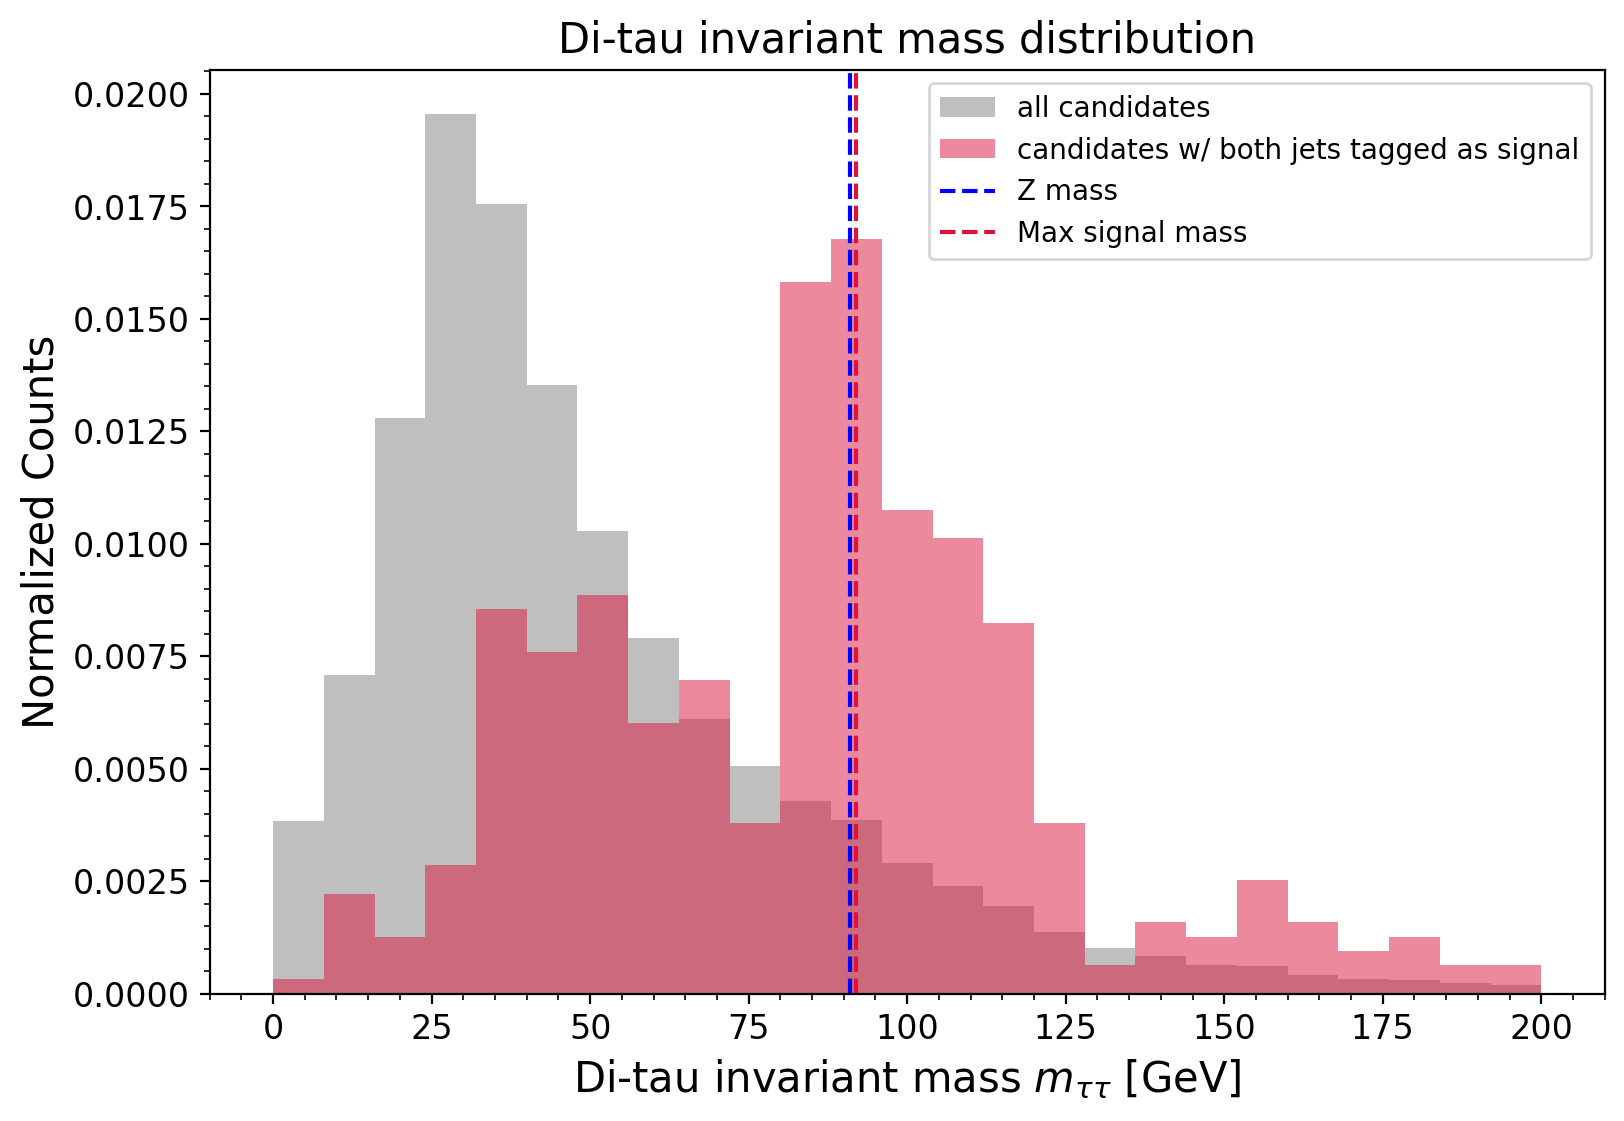

Peak of signal mass distribution at: 92.0


In [ ]:
threshold = 0.5

# STEP 1
in1_mix_scores = model(in1_mix).detach().numpy()
in2_mix_scores = model(in2_mix).detach().numpy()

in1_mix_tag = in1_mix_scores > threshold
in2_mix_tag = in2_mix_scores > threshold
di_tau_tag = (in1_mix_tag & in2_mix_tag).flatten()

# STEP 2
m_mix_sigtagged = m_mix.detach().numpy()[di_tau_tag]

# STEP 3
def rice_optimal_bins(data: np.array) -> int:
    """ The Rice rule for optimal bin selection
    Parameters: 
        data (np.array) - a one-dimensional array with data
    Returns:
        nbins (int) - number of bins
    Function from: https://medium.com/@maxmarkovvision/optimal-number-of-bins-for-histograms-3d7c48086fde
    """
    import math
    assert data.ndim == 1
    n = data.size
    width = 2 * n**(1./3)
    
    nbins = math.ceil((data.max() - data.min()) / width)
    nbins = max(1, nbins)
    
    return nbins


bins = np.linspace(0, 200, rice_optimal_bins(m_mix_sigtagged))
print("Number of bins:", len(bins)-1)
plt.hist(m_mix.detach().numpy(), bins=bins, color="grey", label="all candidates", alpha=0.5, density=True)
plt.hist(m_mix_sigtagged, bins=bins, color="crimson", label="candidates w/ both jets tagged as signal", alpha=0.5, density=True)
plt.xlabel(r"Di-tau invariant mass $m_{\tau\tau}$ [GeV]")
plt.ylabel(r"Normalized Counts")
# Add minor ticks
plt.minorticks_on()
plt.axvline(91, color="blue", linestyle="--", label="Z mass")
plt.axvline(bins[np.argmax(np.histogram(m_mix_sigtagged, bins=bins)[0])] + 0.5 * (bins[1] - bins[0]), color="crimson", linestyle="--", label="Max signal mass")
plt.title("Di-tau invariant mass distribution")
plt.legend(fontsize=10)
plt.show()

print(f"Peak of signal mass distribution at: {bins[np.argmax(np.histogram(m_mix_sigtagged, bins=bins)[0])] + 0.5 * (bins[1] - bins[0])}")